# Writing a JSON file with the borders of all swiss cantons and communes

In [1]:
import shapefile
import unidecode
import matplotlib.pyplot as plt
import json


## Data
The data comes from swisstopo's swissBOUNDARIES3D dataset. This dataset contains the borders of all swiss cantons and communes in ESRI Shapefile format. To download the ESRI Shapefile click [here](https://data.geo.admin.ch/ch.swisstopo.swissboundaries3d/swissboundaries3d_2021-07/swissboundaries3d_2021-07_2056_5728.shp.zip).


In [14]:
DATA_FILE_PATH = 'data/' #change path if needed
COMUNES_PATH = DATA_FILE_PATH  + "swissboundaries3d_2022-01_2056_5728.shp/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_HOHEITSGEBIET.shp"
commune_sf = shapefile.Reader(COMUNES_PATH)
CANTON_PATH = DATA_FILE_PATH + "swissboundaries3d_2022-01_2056_5728.shp/SHAPEFILE_LV95_LN02/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET.shp"
canton_sf = shapefile.Reader(CANTON_PATH)

we have now loaded the shapefile containing all the cantons' borders in `canton_sf` and the shapefile containing all the communes' borders in `commune_sf`

## Pre-processing

To use it with D3 and JS, we would like to preprocess our data that is in ESRI Shapefile format in the following format to later dump it it all in a json file:

The format is a list of dictionaries with 4 fields:   
* **name** : name of canton
* **canton_number**: id of the canton
* **border**: list of coordinates containing border of canton
* **communes**: a dictionary containing all info of all communes within the canton. One can access a commune by its BFS number (id of a commune). Each commune dictionary has 3 fields:
    *  **name**: name of commune
    * **border**: coordinates of the border
    * **canton_number**: id of the canton that the commune is in


To do so we will have to define a couple of helper functions:

In [19]:
def seperate_by_borders(coordinates):
    """some records contain the coordinates of more than one border. Therefore we must seperate these in seperate lists"""
    #input: - coordinates: which is a list of coordinates
    #output: - ls_of_borders which is a list of list. Each list is a border (either of a commune or a canton depending what we called)
    ls_of_borders = []
    border_start = None
    tmp = []
    #iterate coordinates
    for i,(coord) in enumerate(coordinates):
        if border_start is None:
            #if therer is no starting coordinate define one
            border_start = coord
            tmp = []
            #append to tmp which is a list that keeps all the coordinates of a border
            tmp.append(coord)
        
        #if we find a coordinate that is the same as border start, then we have a closed loop of coordinates.
        # which means that we have a full border
        elif coord == border_start or  i == len(coordinates)-1:
            tmp.append(coord)
            #append border to final solution
            ls_of_borders.append(tmp)
            border_start = None
            
        #if we don't find a coordinate that is the same as border start, then we don't have a closed loop of coordinates. 
        else:
            #keep on appending coordinates to tmp
            tmp.append(coord)
            
    return ls_of_borders
     

def order_coordinates(area):
    """Function that identifies all of the borders of a canton or a commune. In fact, there may be more than one border
        (e.g. look on google maps the for ticino. There is more than one border. One is the outer border of ticino. But
        there is also a border between ticino and campione d'italia) """

    #list containing all borders
    all_borders = []
    ls_of_borders = []
    for record in area:
        #get coordinates of record
        coordinates = record.shape.points
        #first border
        ls_of_borders = seperate_by_borders(coordinates)

        for border in ls_of_borders:
            all_borders.append(border)

    
    return all_borders
    

In [4]:

def fetch_communes_dictionary(sf):
    """Accesses data from shapefile and returns all swiss communes in dictionary"""
    #input: sf: data loaded from shapefile
    #output: dictionary with 3 keys: name (name of commune),
    #                                border (coordinates of the border),
    #                                canton_number (id of canton that the commune is in)
    communes = dict()
    #iterate shapefile
    for i in range(len(sf)):
        #acces record 
        rec = sf.shapeRecord(i)
        
        #BFS_NUMMER is the id of the commune. and rec.record['OBJEKTART'] == 'Gemeindegebiet'
        #checks if the record is about a commune
        
        #checks if one of the borders of the commune is already in the dictionary, if yes append record
        if rec.record['BFS_NUMMER'] in communes and rec.record['OBJEKTART'] == 'Gemeindegebiet':
            communes[rec.record['BFS_NUMMER']].append(rec)
        #if one of the borders of the commune is not already in the dictionary, add record in a list
        elif rec.record['BFS_NUMMER'] not in communes and rec.record['OBJEKTART'] == 'Gemeindegebiet':
            communes[rec.record['BFS_NUMMER']] = [rec]
    
    
    for commune in communes:
        #puts all borders of a commune into one single list of coodinates
        commune_border = order_coordinates(communes[commune].copy())
        #fetch the name of the commune
        commune_name = communes[commune][0].record['NAME']
        #remove accents
        commune_name = unidecode.unidecode(commune_name)
        #fetch id of canton that the commune is in
        canton_number = communes[commune][0].record['KANTONSNUM']
        #add info
        communes[commune] = {'name': commune_name, 'border': commune_border, 'canton_number': canton_number}
    return communes

def fetch_cantons_dictionary(canton_sf):
    """Accesses data from shapefile and returns all swiss cantons in dictionary"""
    #input: sf: data loaded from shapefile
    #output: dictionary with 3 keys: name (name of canton),
    #                                border (coordinates of the border),
    #                                canton_number (id of canton)
    canton_info = dict()
    
    #iterate records of shapefile
    for i in range(len(canton_sf)):
        #KANTONSNUM is the id of the canton. and rec.record['OBJEKTART'] == 'Kanton'
        #checks if the record is about a kanton
        
        #checks if one of the borders of the canton is already in the dictionary, if yes append record
        rec = canton_sf.shapeRecord(i)
        if rec.record['KANTONSNUM'] in canton_info and rec.record['OBJEKTART'] == 'Kanton':
            canton_info[rec.record['KANTONSNUM']].append(rec)
        #if one of the borders of the canton is not already in the dictionary, add record in a list
        elif rec.record['KANTONSNUM'] not in canton_info and rec.record['OBJEKTART'] == 'Kanton':
            canton_info[rec.record['KANTONSNUM']] = [rec]
   
    for canton in canton_info:
        #puts all borders of a canton into one single list of coodinates
        canton_border = order_coordinates(canton_info[canton].copy())
        #fetch the name of the canton
        canton_name = canton_info[canton][0].record['NAME']
        #remove accents
        canton_name = unidecode.unidecode(canton_name)
        #fetch id of canton
        canton_number = canton_info[canton][0].record['KANTONSNUM']
        #add info
        canton_info[canton] = {'name': canton_name,'canton_number': canton_number ,'border': canton_border}
    return canton_info

def merge_communes_in_canton_dictionary(canton_dict,commune_dict):
    """puts info of commune dictionary in canton dictionary"""
    # input: canton_dict: dictionary containing info of all cantons
    #       commune_dict: dictionary containing info of all communes
    # output: dictionary with 4 keys: - name: name of canton
    #                                  - canton_number: id of the canton
    #                                  - border: list of list of coordinates containing border of canton 
    #                                           (there is more than one list of coordinates if there the borders are not all connected)
    #                                           (e.g there exist internal borders)
    #                                  - communes: dictonary containing all info of all communes in canton. Can access
    #                                              commune by its BFS number (id of a commune)
    #                                              dictionary has 3 keys:
    #                                                           - name (name of commune),
    #                                                           - border (coordinates of the border),
    #                                                           - canton_number (id of canton commune is in)

    for commune in commune_dict:
        
        #lookup what canton the commune belongs to
        canton_number = commune_dict[commune]['canton_number']
       
        #if canton number is None it means it's a commune in Liechtenstein
        if canton_number is not None:
            if 'communes' not in canton_dict[canton_number]:
                canton_dict[canton_number]['communes'] =   {}
            #add commune info to canton in communes fiels
            canton_dict[canton_number]['communes'][commune] = commune_dict[commune]
            
                
    
    return canton_dict

def fetch_canton_and_commune_dictionaries(commune_sf,canton_sf):
    """Accesses data from shapefiles and returns all swiss cantons and communes in a dictionary"""
    # input: canton_sf: shapefile containing info of all cantons
    #       commune_sf: shapefile containing info of all communes
    # output: list of dictionaries with 4 keys: - name: name of canton
    #                                  - canton_number: id of the canton
    #                                  - border: list of coordinates containing border of canton
    #                                  - communes: dictonary containing all info of all communes in canton. Can access
    #                                              commune by its BFS number (id of a commune)
    #                                              dictionary has 3 keys:
    #                                                           - name (name of commune),
    #                                                           - border (coordinates of the border),
    #                                                           - canton_number (id of canton commune is in)
    
    #fetch communes
    commune_dict = fetch_communes_dictionary(commune_sf)
    
    #fetch cantons
    canton_dict = fetch_cantons_dictionary(canton_sf)
    #put both together
    canton_and_commune_dictionary = merge_communes_in_canton_dictionary(canton_dict,commune_dict)
    return list(canton_and_commune_dictionary.values())

Now that we defined our helper functions, let's retrieve the data in our desired format 

In [5]:
cantons = fetch_canton_and_commune_dictionaries(commune_sf,canton_sf)

## Visualization

Now that we have our data, let's visualize these borders!

### Visualizing canton borders

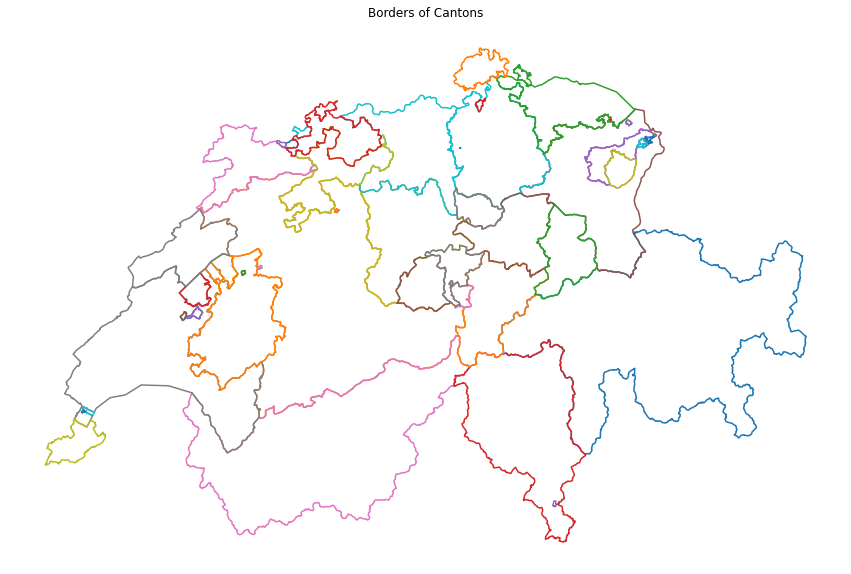

In [40]:

def plot_all_cantons(cantons):
    plt.rcParams["figure.figsize"] = (15,10)
    for canton in cantons:
        for border in canton['border']:
            coord_x = list(map(lambda x: x[0], border))
            coord_y = list(map(lambda x: x[1],border))
            plt.plot(coord_x,coord_y)
    plt.title('Borders of Cantons')
    plt.axis('off')
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
plot_all_cantons(cantons)

### Visualizing commune borders

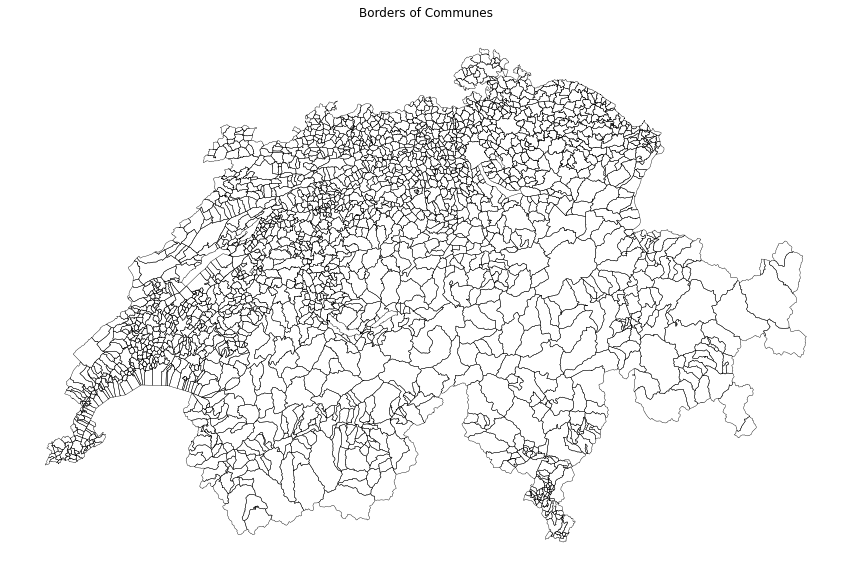

In [42]:
def plot_all_communes(cantons):
    plt.rcParams["figure.figsize"] = (15,10)
    for canton in cantons:
        for commune in canton['communes']:
            for border in canton['communes'][commune]['border']:
                coord_x = list(map(lambda x: x[0], border))
                coord_y = list(map(lambda x: x[1],border))
                plt.plot(coord_x,coord_y,color = 'black',linewidth=0.4)
    plt.title('Borders of Communes')
    plt.axis('off')
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

plot_all_communes(cantons)

## Writing the JSON FILE

Finally let's dump our data in a json file:

In [38]:

def write_json(cantons):
    with open("data/swiss_borders.json", "w") as final:
        json.dump(cantons, final)

In [39]:
write_json(cantons)